In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My Drive/Machine Learning/Food CNN

/content/drive/My Drive/Machine Learning/Food CNN


In [3]:
ls


 Data/  'small data'/   test/   test.txt   train/   train.txt


In [4]:
import random
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, load_model

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

import h5py
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


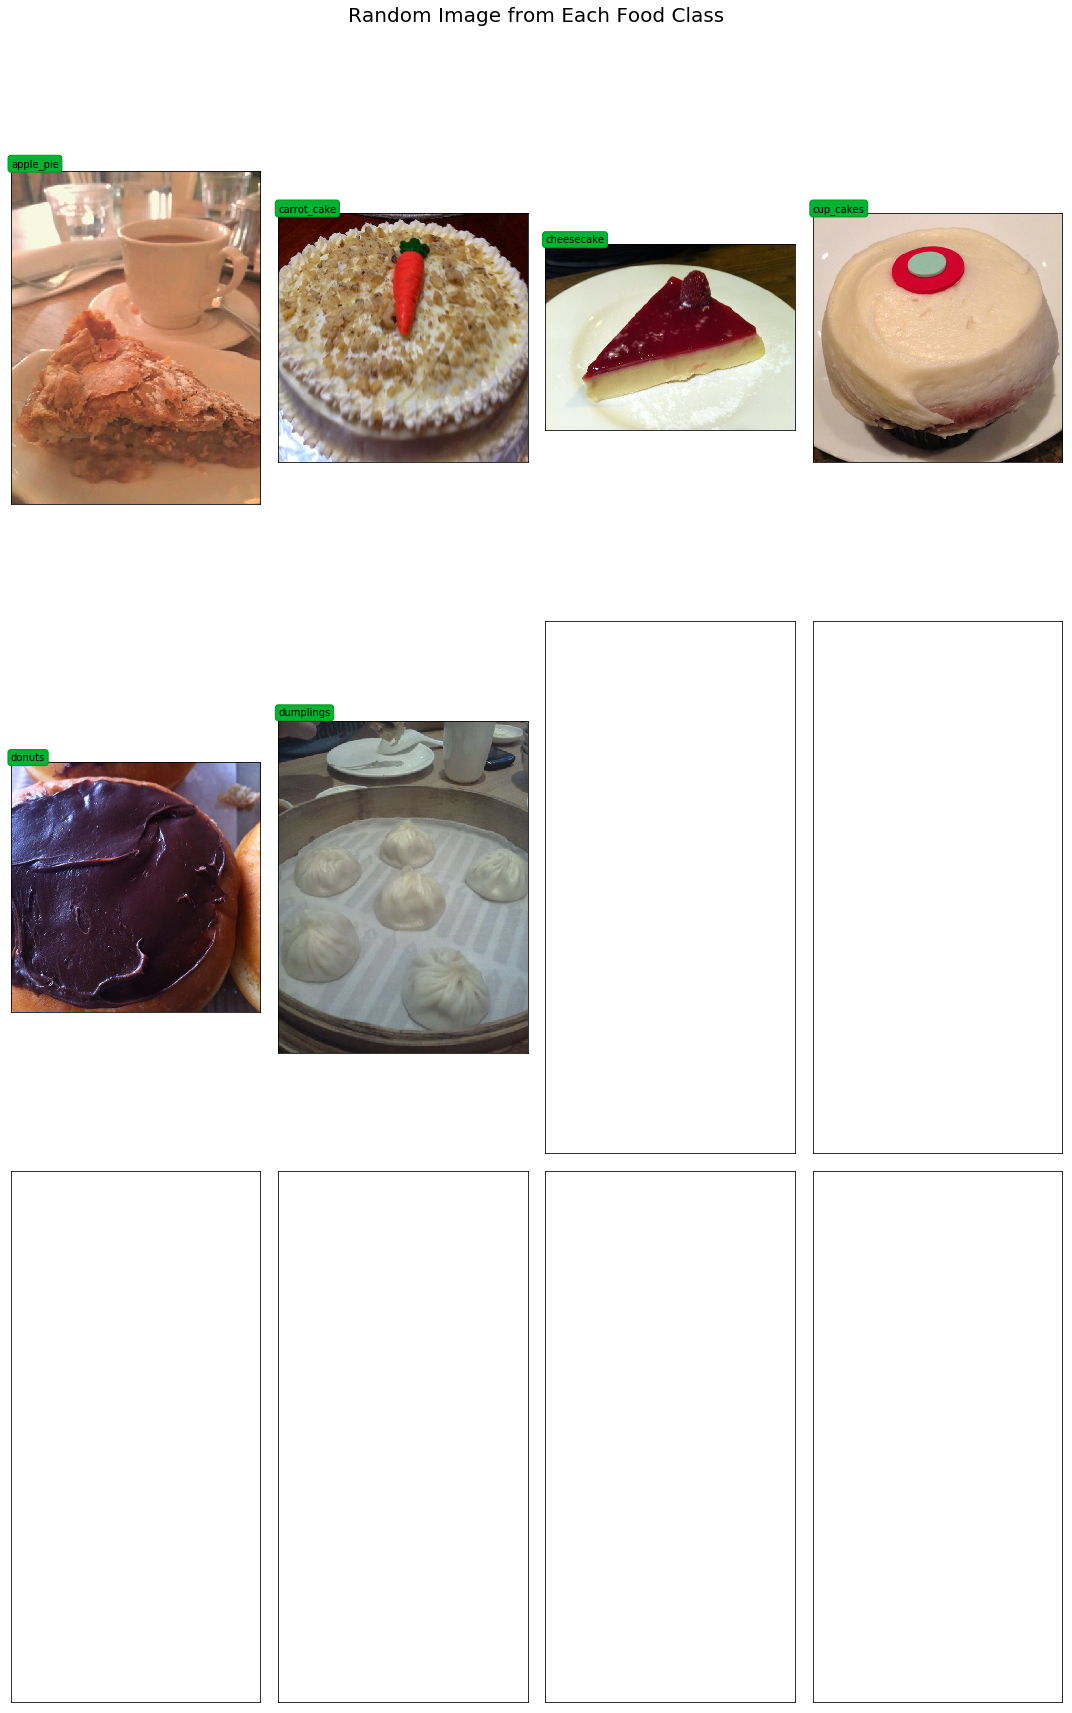

In [36]:
root_dir = 'train/'
rows = 3
cols = 4
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [6]:
# Only split files if haven't already
if not os.path.isdir('test') and not os.path.isdir('train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('train.txt')
    test_dir_files = generate_dir_file_map('test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('images', 'test', ignore=ignore_train)
    copytree('images', 'train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

Train/Test files already copied into separate folders.


In [7]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2532296283041004700, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8955137666809900431
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10826272805606717289
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12102644468739177555
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [8]:
import psutil
psutil.virtual_memory()

svmem(total=13655228416, available=12554059776, percent=8.1, used=846221312, free=10446016512, active=913022976, inactive=1935523840, buffers=75538432, cached=2287452160, shared=3014656, slab=171474944)

In [0]:
import random
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, load_model

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

import h5py
from sklearn.model_selection import train_test_split

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import keras.backend as K
import math

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input

In [0]:
inc = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))

In [51]:
x = inc.output
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(.2)(x) # Dropout slows training down
x = Flatten()(x)
predictions = Dense(6, kernel_initializer='glorot_uniform', kernel_regularizer=l2(.0005), activation='softmax')(x)

model = Model(inputs=inc.input, outputs=predictions)

#model = load_model(filepath='inceptionv3_3.hdf5')

#opt = SGD(lr=0.01, momentum=.9)
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='inceptionv3_4.hdf5', verbose=1, save_best_only=True)

batch_size = 64

train_datagen = ImageDataGenerator(rescale=1./255,
                   rotation_range=10,
                   width_shift_range=0.05,
                   height_shift_range=0.05,
                   zoom_range=0.2,  # 0.75,
                   channel_shift_range=10,
                   shear_range=0.05,
                   horizontal_flip=True,
                   fill_mode="constant")

test_datagen = ImageDataGenerator(rescale=1./255,
                   rotation_range=10,
                   width_shift_range=0.05,
                   height_shift_range=0.05,
                   zoom_range=0.2,  # 0.75,
                   channel_shift_range=10,
                   shear_range=0.05,
                   horizontal_flip=True,
                   fill_mode="constant")

train_generator = train_datagen.flow_from_directory(
        'train',  # this is the target directory
        target_size=(299, 299),
        batch_size=batch_size,
        shuffle = True,
        class_mode='categorical')

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(299, 299),
        batch_size=batch_size,
        shuffle = True,
       class_mode='categorical')


history = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=3,
                    verbose=1,
                    callbacks= [checkpointer])

Found 5990 images belonging to 6 classes.
Found 2305 images belonging to 6 classes.


KeyboardInterrupt: ignored

In [47]:
opt = SGD(lr=0.001, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='inceptionv3_3_1.hdf5', verbose=1, save_best_only=True)
model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    verbose=1,
                    callbacks= [checkpointer])

Epoch 1/1
94/94 [==============================] - 298s 3s/step - loss: 0.4051 - acc: 0.8662 - val_loss: 0.3388 - val_acc: 0.8911

Epoch 00001: val_loss improved from inf to 0.33878, saving model to inceptionv3_3_1.hdf5


In [69]:
# save model and architecture to single file
model.save("modelFood_6.h5")
print("Saved model to disk")

Saved model to disk


Predict images

In [0]:
from numpy import loadtxt
from keras.models import load_model

In [0]:
model = load_model('inceptionv3_3_1.hdf5')
# summarize model.
#model.summary()

['apple_pie ', ' carrot_cake ', ' cheesecake ', ' cup_cakes ', ' donuts /n /dumplings']


In [0]:
target_size = (299, 299) #fixed size for InceptionV3 architecture

def plot_preds(image, preds, top_n):  
    plt.imshow(image)
    plt.axis('off')
    plt.figure()
    
    order = list(reversed(range(top_n)))
    labels = [categories[x] for i, x in enumerate(np.argsort(-probabilities)[:top_n])]
    bar_preds = [-np.sort(-probabilities)[i] for i, x in enumerate(np.argsort(-probabilities)[:top_n])]
    
    plt.barh(order, bar_preds, alpha=0.8, color='g')
    plt.yticks(order, labels, color='g')
    plt.xlabel('Probability', color='g')
    plt.xlim(0, 1.01)
    plt.tight_layout()
    plt.show()

In [0]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

['apple_pie ', ' carrot_cake ', ' cheesecake ', ' cup_cakes ', ' donuts ', ' dumplings'] 6
[0.02766762 0.04976722 0.09642894 0.06831569 0.7458856  0.01193493]


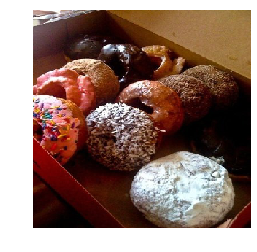

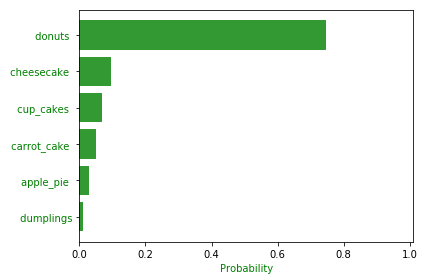

 donuts  74.58856105804443
 cheesecake  9.642893821001053
 cup_cakes  6.831569224596024
 carrot_cake  4.976721853017807
apple_pie  2.7667615562677383
(' donuts ', 74.58856105804443)


In [70]:
string_class = "apple_pie \n carrot_cake \n cheesecake \n cup_cakes \n donuts \n dumplings"
categories = string_class.splitlines()
print(categories, len(categories))


apple_pie_image = './train/apple_pie/134.jpg'
carrot_cake_image = './train/carrot_cake/2666.jpg'
cheesecake_image = './train/cheesecake/35298.jpg'
cup_cakes_image = './train/cup_cakes/7806.jpg'

donuts_image = './train/donuts/1765.jpg'
dumpling_image = './train/dumplings/467.jpg'

img, x = get_image(donuts_image)
probabilities = model.predict(x)[0]
print(probabilities)
plot_preds(img, probabilities, 6)
[print(categories[x], (-np.sort(-probabilities)[i]*100)) for i, x in enumerate(np.argsort(-probabilities)[:5])];
result = [( categories[x], (-np.sort(-probabilities)[i]*100)) for i, x in enumerate(np.argsort(-probabilities)[:5])];
print(result[0])